In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report


In [ ]:
train_dir = "/content/drive/MyDrive/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/FruitinAmazon/test"


In [ ]:
# Define dataset path
# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Number of classes: 6
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


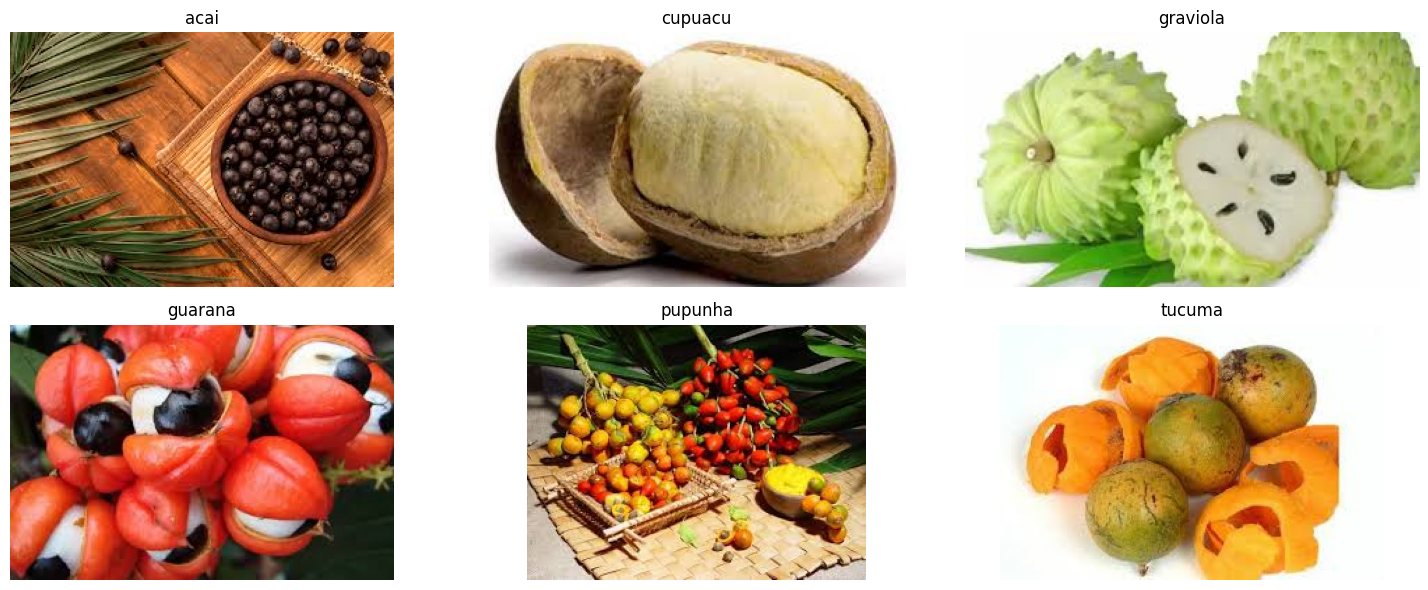

In [ ]:

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Select one random image from each class
images = []
for class_dir in class_names:
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)
        images.append(image_path)

columns = (num_classes + 1) // 2
fig, axes = plt.subplots(2, columns, figsize=(15, 6))
axes = axes.flatten()

# Plot each image
for i, image_path in enumerate(images):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

# Hide any unused axes if num_classes is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image, UnidentifiedImageError
corrupted_images = [] # List to store corrupted images path
# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


In [ ]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [ ]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png','.jpg', '.jpeg'))]
    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)

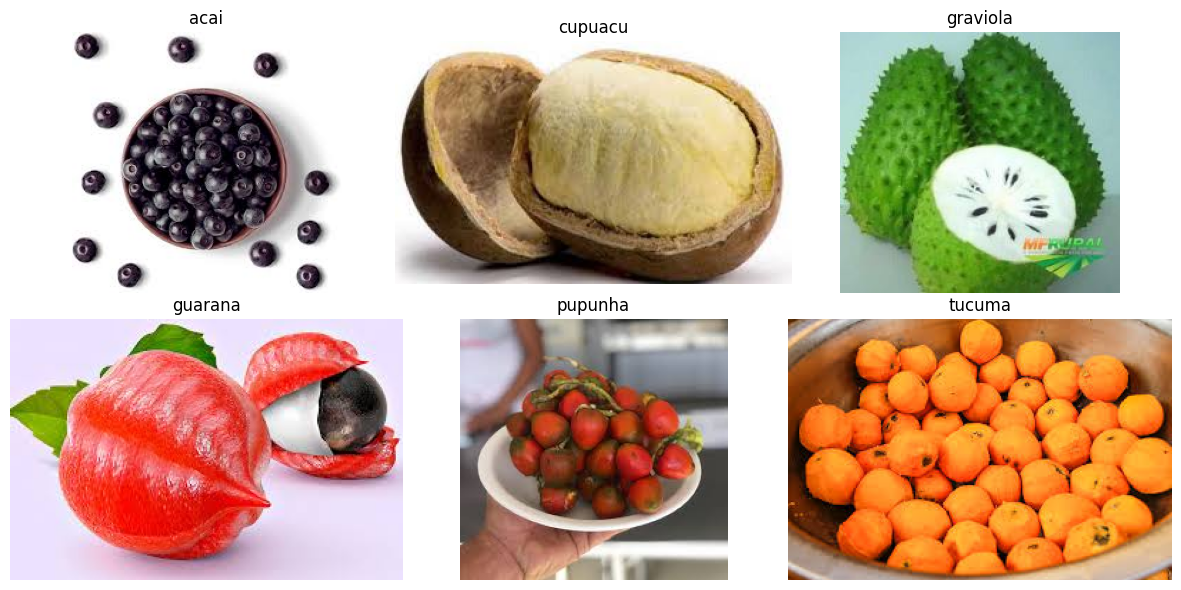

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
  else:
    ax.axis("off") # Hide empty subplots
plt.tight_layout()
plt.show()

In [ ]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 128


# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Convolutional Block 1
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 4
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten
    x = layers.Flatten()(x)

    # Dense Layers
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

# Create the model
model = make_model(input_shape=(224, 224, 3), num_classes=len(class_names))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,670 (100.17 MB)

 Trainable params: 26,254,790 (100.15 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=50,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1222 - loss: 2.1747

1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.1222 - loss: 2.1747 - val_accuracy: 0.2667 - val_loss: 1.8038
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.4556 - loss: 1.3653 - val_accuracy: 0.1667 - val_loss: 1.8166
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.6222 - loss: 1.0215 - val_accuracy: 0.1333 - val_loss: 1.8097
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.7556 - loss: 0.8132 - val_accuracy: 0.2000 - val_loss: 1.7769
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.8111 - loss: 0.7180 - val_accuracy: 0.2000 - val_loss: 1.7768
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.8889 - loss: 0.5880 - val_accuracy: 0.1333 - val_loss: 1.7757
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.8889 - loss: 0.5452 - val_accuracy: 0.1333 - val_loss: 1.7723
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.9222 - loss: 0.4671 - val_accuracy: 0.1000 - val_loss: 1.7670
Epoch 9/50


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 1.7670
Test accuracy: 0.1000
Test loss: 1.7670


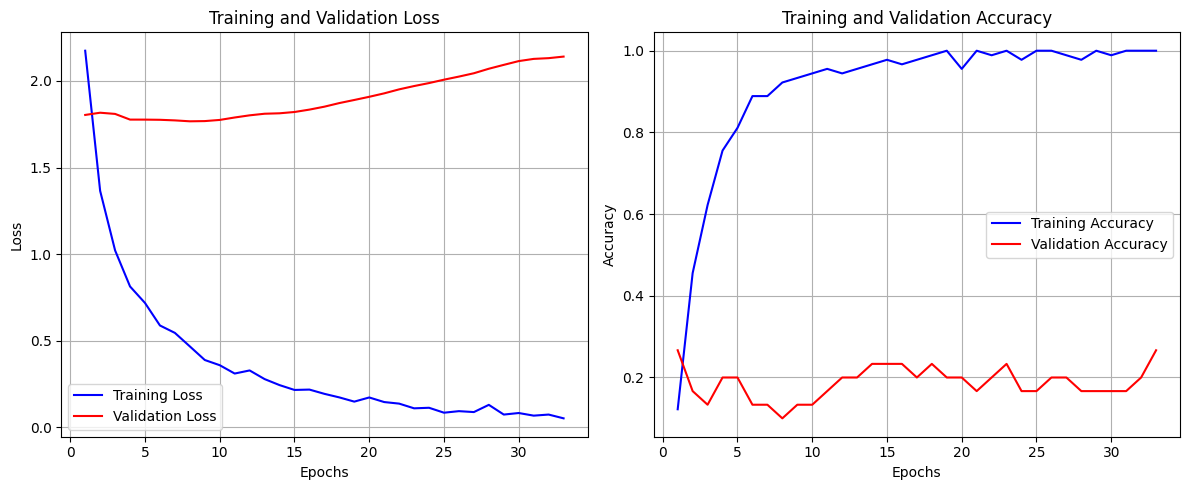

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
model.save('AshrayaPhuyal_w6_task1.h5')
print("Model saved as 'AshrayaPhuyal_w6_task1.h5'")

Model saved as 'AshrayaPhuyal.h5'


In [ ]:

loaded_model = tf.keras.models.load_model('AshrayaPhuyal_w6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1000 - loss: 1.7670
Loaded model test accuracy: 0.1000
Loaded model test loss: 1.7670


In [ ]:
loaded_model = keras.models.load_model('AshrayaPhuyal_w6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.00      0.00      0.00         5
    graviola       0.13      0.60      0.21         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.10        30
   macro avg       0.02      0.10      0.04        30
weighted avg       0.02      0.10      0.04        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TASK 2

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

In [ ]:
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - accuracy: 0.1444 - loss: 4.7768

1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step - accuracy: 0.1444 - loss: 4.7768 - val_accuracy: 0.4000 - val_loss: 6.2498
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - accuracy: 0.5333 - loss: 5.1377

1/1 ━━━━━━━━━━━━━━━━━━━━ 76s 76s/step - accuracy: 0.5333 - loss: 5.1377 - val_accuracy: 0.5333 - val_loss: 6.1488
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64s/step - accuracy: 0.7222 - loss: 4.2956

1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step - accuracy: 0.7222 - loss: 4.2956 - val_accuracy: 0.6000 - val_loss: 5.4275
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 87s 87s/step - accuracy: 0.7889 - loss: 3.2031 - val_accuracy: 0.6000 - val_loss: 3.7001
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115s/step - accuracy: 0.8444 - loss: 1.3090

1/1 ━━━━━━━━━━━━━━━━━━━━ 133s 133s/step - accuracy: 0.8444 - loss: 1.3090 - val_accuracy: 0.6333 - val_loss: 2.2669
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65s/step - accuracy: 0.9667 - loss: 0.1156

1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.9667 - loss: 0.1156 - val_accuracy: 0.6667 - val_loss: 2.1334
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 0.9778 - loss: 0.0654 - val_accuracy: 0.6667 - val_loss: 2.5902
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 80s 80s/step - accuracy: 0.9667 - loss: 0.2520 - val_accuracy: 0.6000 - val_loss: 3.1282
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 106s 106s/step - accuracy: 0.9222 - loss: 0.4326 - val_accuracy: 0.6000 - val_loss: 3.0814
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 126s 126s/step - accuracy: 0.9444 - loss: 0.3189 - val_accuracy: 0.6333 - val_loss: 2.6998
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 139s 139s/step - accuracy: 0.9556 - loss: 0.0871 - val_accuracy: 0.6000 - val_loss: 2.3126
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - accuracy: 1.0000 - loss: 0.0071

1/1 ━━━━━━━━━━━━━━━━━━━━ 76s 76s/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.7000 - val_loss: 2.3695
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.7000 - val_loss: 2.5250
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.6667 - val_loss: 2.6300
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.6667 - val_loss: 2.6518
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 79s 79s/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.7000 - val_loss: 2.6182
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 87s 87s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.7000 - val_loss: 2.5602
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7000 - val_loss: 2.5002
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - accuracy: 1.0000 - loss: 0.0016

1/1 ━━━━━━━━━━━━━━━━━━━━ 81s 81s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.7333 - val_loss: 2.4498
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7333 - val_loss: 2.4100
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 1.0000 - loss: 9.2867e-04 - val_accuracy: 0.7333 - val_loss: 2.3812


In [ ]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6667 - loss: 2.1334
Test accuracy for VGG16: 0.6667


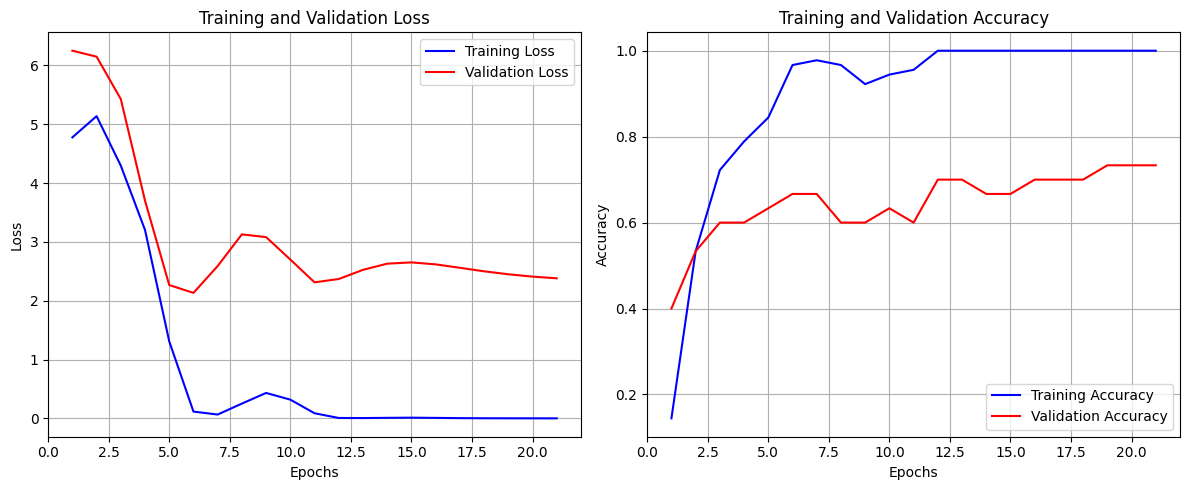

In [ ]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:


predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.62      1.00      0.77         5
     cupuacu       0.80      0.80      0.80         5
    graviola       0.80      0.80      0.80         5
     guarana       1.00      0.60      0.75         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.44      0.80      0.57         5

    accuracy                           0.67        30
   macro avg       0.61      0.67      0.62        30
weighted avg       0.61      0.67      0.62        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
